# Gait classification

## Libraries and directory

In [1]:
#import packages, there might be some extras
import time
import os
import platform

import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import keras.utils
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import imageio
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 'large'


In [2]:
if tf.config.list_physical_devices('GPU'):
    print("GPU support is enabled.")
else:
    print("GPU support is NOT enabled.")

GPU support is NOT enabled.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/Human_Data/Progetto/dataset-20240610T153249Z-001.zip" -d "/content"

Archive:  /content/drive/MyDrive/Human_Data/Progetto/dataset-20240610T153249Z-001.zip
  inflating: /content/dataset/subject4/lurching/trial1/Sbj4_lurching_T1_P.csv  
  inflating: /content/dataset/subject4/lurching/trial19/Sbj4_lurching_T19_S.csv  
  inflating: /content/dataset/subject4/lurching/trial10/Sbj4_lurching_T10_P.csv  
  inflating: /content/dataset/subject4/lurching/trial20/Sbj4_lurching_T20_S.csv  
  inflating: /content/dataset/subject4/lurching/trial4/Sbj4_lurching_T4_S.csv  
  inflating: /content/dataset/subject4/lurching/trial10/Sbj4_lurching_T10_S.csv  
  inflating: /content/dataset/subject4/lurching/trial9/Sbj4_lurching_T9_S.csv  
  inflating: /content/dataset/subject4/lurching/trial6/Sbj4_lurching_T6_S.csv  
  inflating: /content/dataset/subject4/lurching/trial17/Sbj4_lurching_T17_S.csv  
  inflating: /content/dataset/subject4/lurching/trial18/Sbj4_lurching_T18_P.csv  
  inflating: /content/dataset/subject4/lurching/trial11/Sbj4_lurching_T11_S.csv  
  inflating: /conten

In [5]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition'
else:
    root_directory = '/content'
    # root_directory = '/content/drive/MyDrive/Progetto'

print('root directory is ' + root_directory)

root directory is /content


## Train/Test Split


In [6]:
# Create a dataframe containing all the files and the labels from the reference file
reference_df = pd.read_csv('/content/drive/MyDrive/Human_Data/Progetto/reference_document.csv',
                           header=None, names=['Name_file', 'Path_from_Root', 'Type_of_data', 'Type_of_gait', 'Label'])

reference_df = reference_df.iloc[1:]                            # fa iniziare il numero di colonne da 1 al posto che da zero
reference_df['Label'] = reference_df['Label'].astype(int)

reference_df

,Name_file,Path_from_Root,Type_of_data,Type_of_gait,Label
1,Sbj9_antalgic_T2_S.csv,subject9/antalgic/trial2/,skeleton,antalgic,0
2,Sbj9_antalgic_T2_P.csv,subject9/antalgic/trial2/,pressure,antalgic,0
3,Sbj9_antalgic_T8_S.csv,subject9/antalgic/trial8/,skeleton,antalgic,0
4,Sbj9_antalgic_T8_P.csv,subject9/antalgic/trial8/,pressure,antalgic,0
5,Sbj9_antalgic_T14_P.csv,subject9/antalgic/trial14/,pressure,antalgic,0
...,...,...,...,...,...
2876,Sbj8_normal_T17_S.csv,subject8/normal/trial17/,skeleton,normal,2
2877,Sbj8_normal_T10_P.csv,subject8/normal/trial10/,pressure,normal,2
2878,Sbj8_normal_T10_S.csv,subject8/normal/trial10/,skeleton,normal,2
2879,Sbj8_normal_T6_P.csv,subject8/normal/trial6/,pressure,normal,2


In [7]:
def complete_path(row):
  complete_path = root_directory + '/dataset/' + row['Path_from_Root'] + row['Name_file']
  return complete_path

reference_df['Complete_path'] = reference_df.apply(complete_path, axis=1)
reference_df.set_index('Complete_path', inplace=True)                       # imposta Complete_path come indice per la mia tabella
reference_df = reference_df.drop(columns=['Path_from_Root'])
reference_df

,Name_file,Type_of_data,Type_of_gait,Label
Complete_path,,,,
/content/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_S.csv,Sbj9_antalgic_T2_S.csv,skeleton,antalgic,0
/content/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_P.csv,Sbj9_antalgic_T2_P.csv,pressure,antalgic,0
/content/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_S.csv,Sbj9_antalgic_T8_S.csv,skeleton,antalgic,0
/content/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_P.csv,Sbj9_antalgic_T8_P.csv,pressure,antalgic,0
/content/dataset/subject9/antalgic/trial14/Sbj9_antalgic_T14_P.csv,Sbj9_antalgic_T14_P.csv,pressure,antalgic,0
...,...,...,...,...
/content/dataset/subject8/normal/trial17/Sbj8_normal_T17_S.csv,Sbj8_normal_T17_S.csv,skeleton,normal,2
/content/dataset/subject8/normal/trial10/Sbj8_normal_T10_P.csv,Sbj8_normal_T10_P.csv,pressure,normal,2
/content/dataset/subject8/normal/trial10/Sbj8_normal_T10_S.csv,Sbj8_normal_T10_S.csv,skeleton,normal,2


In [8]:
# recall
# LABELS = np.array(['antalgic', 'lurching', 'normal', 'steppage', 'stifflegged', 'trendelenburg'])

#split the dataframe into skeleton and pressure, drop the type column

reference_df_s = reference_df[reference_df['Type_of_data']=='skeleton']
reference_df_s = reference_df_s.drop(columns=['Type_of_data', 'Type_of_gait'])

reference_df_p = reference_df[reference_df['Type_of_data']=='pressure']
reference_df_p = reference_df_p.drop(columns=['Type_of_data', 'Type_of_gait'])


# We want to split the data using 11 subjects as training set and 1 subject as test set
# In this way we are sure that train and test are completely dinstinct

# train_test split
train_s = reference_df_s[~reference_df_s['Name_file'].str.startswith('Sbj12')]
val_s = reference_df_s[reference_df_s['Name_file'].str.startswith('Sbj12')]

train_p = reference_df_p[~reference_df_p['Name_file'].str.startswith('Sbj12')]
val_p = reference_df_p[reference_df_p['Name_file'].str.startswith('Sbj12')]

train_s = train_s.drop(columns=['Name_file'])
val_s = val_s.drop(columns=['Name_file'])
train_p = train_p.drop(columns=['Name_file'])
val_p = val_p.drop(columns=['Name_file'])


#frequence counts
print("Train Skelly")
print(train_s['Label'].value_counts())
print('\n',"Validation Skelly")
print(val_s['Label'].value_counts())
print('\n',"Train Pressure")
print(train_p['Label'].value_counts())
print('\n',"Validation Pressure")
print(val_p['Label'].value_counts())

Train Skelly
Label
0    220
4    220
5    220
3    220
2    220
1    220
Name: count, dtype: int64

 Validation Skelly
Label
5    20
4    20
0    20
3    20
2    20
1    20
Name: count, dtype: int64

 Train Pressure
Label
0    220
4    220
5    220
3    220
2    220
1    220
Name: count, dtype: int64

 Validation Pressure
Label
5    20
4    20
0    20
3    20
2    20
1    20
Name: count, dtype: int64


## Skeletron: load and preprocessing

### Defenition of the load function

File name:  /content/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_S.csv 

(number of frames, number of points, coords) = (207, 32, 3)


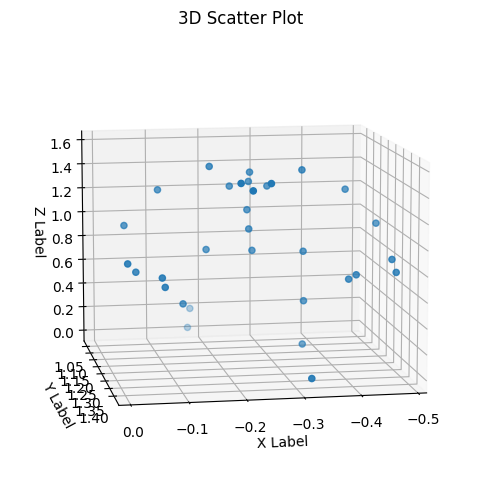

In [9]:
def load_data_sk(complete_path, load=True):

  if load:
    complete_path = complete_path.decode()

  df_skelly = pd.read_csv(complete_path, header=None)
  df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)

  #convert to np array and reshape
  data = df_skelly.to_numpy().reshape((-1,32,3))

  return data.squeeze()


# Example
sk_data = load_data_sk(train_s.index[1], load=False)
print('File name: ', train_s.index[1], '\n')
print('(number of frames, number of points, coords) =', sk_data.shape)

#plot example, select only one frame
plotdata = sk_data[150]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
plt.show()

### Defenition of the normalization function

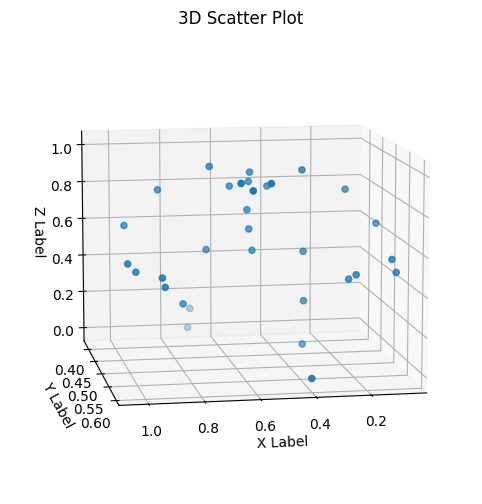

In [10]:
def normalize_data_sk(data):
    # Amplitude estimate for each axes
    norm_factor_x = np.percentile(data[:, :, 0], 95) - np.percentile(data[:, :, 0], 5)
    norm_factor_y = np.percentile(data[:, :, 1], 95) - np.percentile(data[:, :, 1], 5)
    norm_factor_z = np.percentile(data[:, :, 2], 95) - np.percentile(data[:, :, 2], 5)

    data[:, :, 0] = (data[:, :, 0] - np.percentile(data[:, :, 0], 5)) / norm_factor_x
    data[:, :, 1] = (data[:, :, 1] - np.percentile(data[:, :, 1], 5)) / norm_factor_y
    data[:, :, 2] = (data[:, :, 2] - np.percentile(data[:, :, 2], 5)) / norm_factor_z

    return data


# Example
sk_data = load_data_sk(train_s.index[1], load=False)
sk_data_norm = normalize_data_sk(sk_data)


#plot example, select only one frame
plotdata = sk_data[150]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
plt.show()

Perche' all'inizio veloce e poi lenta?

In [11]:
# # check duration of walking samples
# hist = []

# c = 0

# for i in reference_df_s.index:
#     data = load_data_sk(i, reference_df_s)
#     hist.append(data.shape[0])

#     if c % 100 == 0:
#       print('Step:', c)
#     c += 1

# # Create a histogram
# plt.hist(hist, bins=150, edgecolor='black')

# # Add a vertical line for the median
# plt.axvline(np.median(hist), color='red', linestyle='dashed', linewidth=1)
# plt.axvline(np.mean(hist), color='yellow', linestyle='dashed', linewidth=1)

# # Add labels and title
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram')

# # Show the plot
# plt.show()
# print("Median of data (red)",np.median(hist))
# print("Mean of data (yellow)",np.mean(hist))
# print("Standard dev of data", np.std(hist))

### Defenition of the crop function

In [11]:
def random_crop(data, target_size=50, noise_time=20, center_crop=False):

  # remove initial and final frames that we consider as noise
  start = noise_time
  end = data.shape[0] - noise_time

  data = data[start:end, :]

  N = data.shape[0]

  # Random Crop (always centered if center_crop=True)
  if center_crop:
      from_ = int((N / 2) - (target_size / 2))
      # print('Start of the crop: ', from_)
  else:
      from_ = np.random.randint(0, np.floor(N - target_size))
      # print('Start of the crop: ', from_)

  return data[from_:from_ + target_size]


# Example
sk_data = load_data_sk(train_s.index[1], load=False)

sk_data_crop = random_crop(sk_data)
print('Original shape ', sk_data.shape, 'Cropped/Padded shape ', sk_data_crop.shape)

Original shape  (207, 32, 3) Cropped/Padded shape  (50, 32, 3)


### Unique load_preprocessing function

In [12]:
def load_prep_sk_new(complete_path):
    data = load_data_sk(complete_path, load=True)
    data = normalize_data_sk(data)

    return data.astype(np.float32)

## Skeletron dataset

### Classifier

Defenition of the function to create the dataset

In [18]:
def create_dataset_sk(table, cache_file, shuffle, batch_size, target_size=50, noise_time=20, center_crop=False):

  # shape
  input_size = (target_size, 32, 3)

  # Convert dataframe to lists
  file_names = list(table.index)
  labels = table['Label']

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
  # Now, 'dataset' contains tuples of 'file_names' and 'labels', where each tuple represents a single example

  # Map the load_and_preprocess_data function
  py_func = lambda path, label: (tf.numpy_function(load_prep_sk_new, [path], tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Map the crop function
  py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_crop, [data, target_size, noise_time, center_crop], tf.float32),
                                              input_size), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

Dataset inizialization

In [20]:
batch_s = 30

dataset_train_s = create_dataset_sk(table = train_s,
                                    cache_file = 'train_s_cache',
                                    shuffle = True,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)

dataset_val_s = create_dataset_sk(table = val_s,
                                    cache_file = 'val_s_cache',
                                    shuffle = False,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)

train_steps_s = int(np.ceil(len(train_s)/batch_s))
val_steps_s = int(np.ceil(len(val_s)/batch_s))

first_element_dataset_k = dataset_train_s.take(1)
first_element_dataset_k

for d, l in first_element_dataset_k:
  print((d.numpy().shape), l.numpy().shape)

(30, 50, 32, 3) (30,)


### Autoencoders

Defenition of the function to create the dataset

In [ ]:
def create_dataset_autoencoders_sk(table, cache_file, shuffle, batch_size, target_size=50, noise_time=20, center_crop=False):

  # shape
  input_size = (target_size, 96)

  # Convert dataframe to lists
  file_names = list(table.index)

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names))

  # Map the load_and_preprocess_data function
  py_func = lambda path: (tf.numpy_function(load_prep_sk, [path], tf.float32))
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Map the crop function
  py_func = lambda data: (tf.ensure_shape(tf.numpy_function(random_crop, [data, target_size, noise_time, center_crop], tf.float32), input_size))
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # After the cache to be sure that they have the same data
  # Duplicate data for the autoencoder (input = output)
  py_funct = lambda data: (data, data)
  dataset = dataset.map(py_funct)

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

Dataset inizialization

In [ ]:
batch_s = 30

dataset_train_s_autoencoder = create_dataset_autoencoders_sk(table = train_s,
                                    cache_file = 'train_s_cache_autoencoder',
                                    shuffle = True,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)

dataset_val_s_autoencoder = create_dataset_autoencoders_sk(table = val_s,
                                    cache_file = 'val_s_cache_autoencoder',
                                    shuffle = False,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)


train_steps_s = int(np.ceil(len(train_s)/batch_s))
val_steps_s = int(np.ceil(len(val_s)/batch_s))

first_element_dataset_k = dataset_train_s_autoencoder.take(1)
first_element_dataset_k

for d, l in first_element_dataset_k:
  print(d.numpy().shape, l.numpy().shape)
  print(np.array_equal(d.numpy(), l.numpy()))

(30, 50, 96) (30, 50, 96)
True


## Pressure: load and preprocessing

### Defenition of the load function

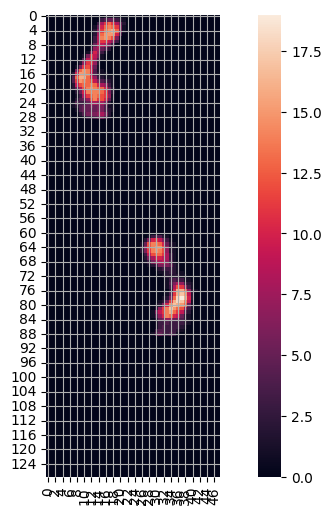

In [ ]:
def load_data_ps(complete_path, load=True):

  if load:
    complete_path = complete_path.decode()

  pressure_data = pd.read_csv(complete_path, header=None).to_numpy()

  return pressure_data.squeeze()


# Example
ps_data = load_data_ps(train_p.index[330], load=False)

sns.heatmap(ps_data, square= True)
plt.show()

### Defenition of the normalization function

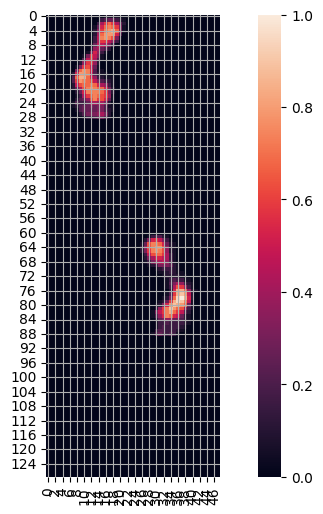

In [ ]:
def normalize_data_ps(data):
    massimo = np.max(data)
    data = data / massimo
    return data

# Example
ps_data = load_data_ps(train_p.index[330], load=False)
ps_data_norm = normalize_data_ps(ps_data)

sns.heatmap(ps_data_norm, square= True)
plt.show()

### Defenition of the centering function

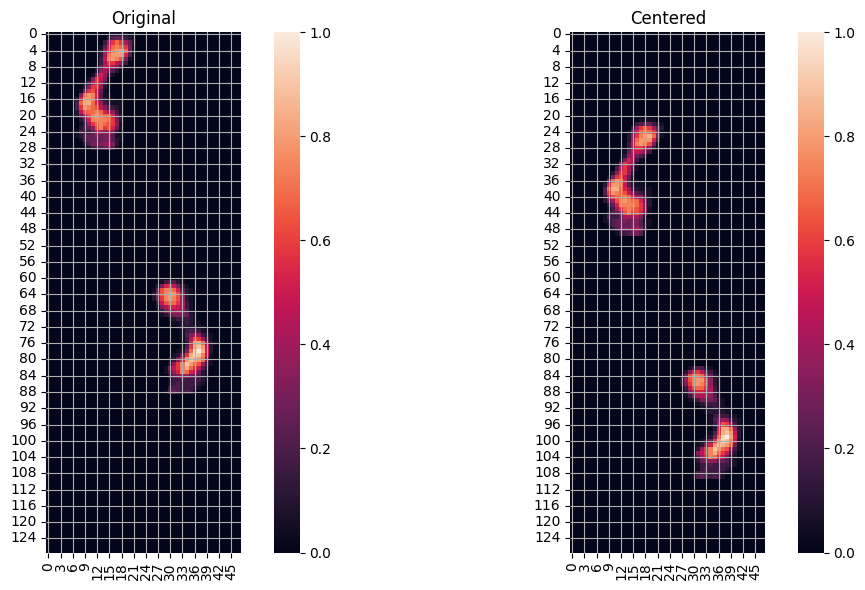

In [ ]:
def baricenter(data):
  # Compute the weighted average (barycenter) along each dimension
  y_barycenter = np.average(np.arange(data.shape[0]), weights=np.sum(data, axis=1))
  x_barycenter = np.average(np.arange(data.shape[1]), weights=np.sum(data, axis=0))

  # print("Barycenter coordinates (x,y) = ",x_barycenter,y_barycenter)
  # print("Center image (x,y) = ", data.shape[1]/2, data.shape[0]/2)

  # Compute the distances between each point and the barycenter
  shift_x = -(x_barycenter - data.shape[1]/2)
  shift_y = -(y_barycenter - data.shape[0]/2)

  # Shift the foot pressure matrix to be centered on the barycenter
  shifted_matrix = np.roll(data, int(shift_x), axis=1)
  shifted_matrix = np.roll(shifted_matrix, int(shift_y), axis=0)

  # y_barycenter_after = np.average(np.arange(shifted_matrix.shape[0]), weights=np.sum(shifted_matrix, axis=1))
  # x_barycenter_after = np.average(np.arange(shifted_matrix.shape[1]), weights=np.sum(shifted_matrix, axis=0))
  # print("Barycenter coordinates (x,y) afetr= ", x_barycenter_after, y_barycenter_after, '\n')

  return shifted_matrix

# Example
ps_data = load_data_ps(train_p.index[330], load=False)
ps_data_norm = normalize_data_ps(ps_data)
cen_ps_data_norm = baricenter(ps_data_norm)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first heatmap
sns.heatmap(ps_data_norm, square=True, ax=axes[0])
axes[0].set_title('Original')

# Plot the second heatmap
sns.heatmap(cen_ps_data_norm, square=True,ax=axes[1])
axes[1].set_title('Centered')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Unique load_preprocessing function

In [ ]:
def load_prep_ps(complete_path):
    data = load_data_ps(complete_path, load=True)
    data = normalize_data_ps(data)
    data = baricenter(data)

    return data.astype(np.float32)



# # to try you have to set load=False
# ps_data_end = load_prep_ps(train_p.index[330])

# # Plot the first heatmap
# sns.heatmap(ps_data_end, square=True)
# plt.show()

## Pressure dataset

### Classifier

Defenition of the function to create the dataset

In [ ]:
def create_dataset_ps(table, cache_file, shuffle, batch_size):

  # Convert dataframe to lists
  file_names = list(table.index)
  labels = file_names

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

  # Map the load_and_preprocess_data function
  py_func = lambda path, label: (tf.numpy_function(load_prep_ps, [path], tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Correct input shape for the network
  dataset = dataset.map(lambda img, label: (tf.expand_dims(img, 2), label))

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

Dataset inizialization

In [ ]:
batch_p = 20

dataset_train_p = create_dataset_ps(table = train_p,
                                    cache_file = 'train_p_cache',
                                    shuffle = True,
                                    batch_size = batch_p)

dataset_val_p = create_dataset_ps(table = val_p,
                                    cache_file = 'val_p_cache',
                                    shuffle = False,
                                    batch_size = batch_p)

train_steps_p = int(np.ceil(len(train_p)/batch_p))
val_steps_p = int(np.ceil(len(val_p)/batch_p))

### Autoencoders

Defenition of the function to create the dataset

In [ ]:
def create_dataset_autoencoder_ps(table, cache_file, shuffle, batch_size, ):

  # Convert dataframe to lists
  file_names = list(table.index)

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names))

  # Map the load_and_preprocess_data function
  py_func = lambda path: (tf.numpy_function(load_prep_ps, [path], tf.float32))
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Duplicate data for the autoencoder (input = output)
  py_funct = lambda img: (img, img)
  dataset = dataset.map(py_funct)

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Correct input shape for the network
  dataset = dataset.map(lambda img_1, img_2: (tf.expand_dims(img_1, 2), (tf.expand_dims(img_2, 2))))

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

Dataset inizialization

In [ ]:
batch_p = 20

dataset_train_p_autoencoder = create_dataset_autoencoder_ps(table = train_p,
                                    cache_file = 'train_p_cache_autoencoder',
                                    shuffle = True,
                                    batch_size = batch_p)

dataset_val_p_autoencoder = create_dataset_autoencoder_ps(table = val_p,
                                    cache_file = 'val_p_cache_autoencoder',
                                    shuffle = False,
                                    batch_size = batch_p)

train_steps_p = int(np.ceil(len(train_p)/batch_p))
val_steps_p = int(np.ceil(len(val_p)/batch_p))

# first_element_dataset_p = dataset_train_p_autoencoder.take(1)
# first_element_dataset_p

# for d, l in first_element_dataset_p:
#   d_0 = d.numpy()
#   l_0 = l.numpy()
#   print(d.numpy().shape)
#   print(l.numpy().shape)
#   print(np.array_equal(d_0, l_0))

## RNN autoencoders

### Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=False,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, enc_inputs, state=None):
        output, state = self.gru(enc_inputs, initial_state=state)
        return output, state

In [ ]:
# Create a temporary functional model with the Encoder layer
inputs = tf.keras.Input((50, 96))
encoder = Encoder(enc_units=125)
enc_outputs, enc_state = encoder(inputs)

# Print the shape of outputs for debugging
print("Shape of outputs:", enc_outputs.shape)
print("Shape of outputs:", enc_state.shape)


# Create the model
model = tf.keras.Model(inputs, enc_outputs)

# Print the summary of the model
model.summary()

Shape of outputs: (None, 125)
Shape of outputs: (None, 125)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 96)]          0         
                                                                 
 encoder (Encoder)           ((None, 125),             83625     
                              (None, 125))                       
                                                                 
Total params: 83625 (326.66 KB)
Trainable params: 83625 (326.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, dec_units, output_dim):
        super(Decoder, self).__init__()

        self.dec_units = dec_units
        self.output_dim = output_dim

        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=False,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        self.fc = tf.keras.layers.Dense(self.output_dim)

    def call(self, dec_input, state=None):

        dec_output, dec_state = self.gru(dec_input, initial_state=state)

        logits = self.fc(dec_output)


        return logits, dec_output, dec_state

In [ ]:
# Create a temporary functional model with the Encoder layer
inputs = tf.keras.Input((1, 125))
decoder = Decoder(dec_units=225, output_dim=96)
logits, dec_output, dec_state = decoder(inputs)

# Print the shape of outputs for debugging
print("Shape of outputs:", logits.shape)
print("Shape of outputs:", dec_output.shape)
print("Shape of outputs:", dec_state.shape)

# Create the model
model = tf.keras.Model(inputs, dec_output)

# Print the summary of the model
model.summary()

Shape of outputs: (None, 96)
Shape of outputs: (None, 225)
Shape of outputs: (None, 225)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 125)]          0         
                                                                 
 decoder (Decoder)           ((None, 96),              259296    
                              (None, 225),                       
                              (None, 225))                       
                                                                 
Total params: 259296 (1012.88 KB)
Trainable params: 259296 (1012.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=False,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, enc_inputs, state=None):
        output, state = self.gru(enc_inputs, initial_state=state)
        return output, state





class Decoder(tf.keras.layers.Layer):
    def __init__(self, dec_units, output_dim):
        super(Decoder, self).__init__()

        self.dec_units = dec_units
        self.output_dim = output_dim

        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=False,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        self.fc = tf.keras.layers.Dense(self.output_dim)

    def call(self, dec_input, state=None):

        dec_output, dec_state = self.gru(dec_input, initial_state=state)

        logits = self.fc(dec_output)


        return logits, dec_output, dec_state





class TranslatorModelTrain(tf.keras.Model):
    def __init__(self, enc_units, dec_units, output_dim):
        super(TranslatorModelTrain, self).__init__()

        self.encoder = Encoder(enc_units)
        self.decoder = Decoder(dec_units, output_dim)
        self.loss = tf.keras.losses.MeanSquaredError()

    def loop_step(self, dec_input, target, dec_state=None):
        # Run the decoder for one step (pass the proper arguments to self.decoder)
        logits, dec_output, dec_state = self.decoder(dec_input, state=dec_state)
        step_loss = self.loss(target, logits)

        return step_loss, dec_output, dec_state

    def train_step(self, inputs):

        print('Batch 1')
        ae_inputs = inputs[0]
        target_outputs = inputs[1]
        print('Input test:')
        print('inputs_inside:', ae_inputs.shape)
        # print(type(ae_inputs))
        # print(ae_inputs.numpy().shape, target_outputs.numpy().shape)
        # print(np.array_equal(ae_inputs.numpy(), target_outputs.numpy()), '\n')


        max_target_length = tf.shape(ae_inputs)[1]
        # print('seq_len:', max_target_length, '\n')

        with tf.GradientTape() as tape:

            enc_output, enc_state = self.encoder(ae_inputs)
            print('Encoder okay')
            print(enc_state.shape)

            dec_state = enc_state
            loss = tf.constant(0.0)

            for t in tf.range(max_target_length - 1):

                # print('t:', t)
                dec_input = target_outputs[:, t:t+1, :]
                target_dec = target_outputs[:, t+1:t+2, :]
                # print('dec_input:', dec_input.shape)
                # print('target_dec:', target_dec.shape)

                step_loss, dec_output, dec_state = self.loop_step(dec_input, target_dec, dec_state)
                # print('Dec:', dec_state.shape)
                loss = loss + step_loss

            # Average the loss over all non padding tokens.
            # print('Loss:', type(loss))
            # print(type(max_target_length))

            average_loss = loss / tf.cast(max_target_length, dtype=tf.float32)

        variables = self.trainable_variables
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

        return {'batch_loss': average_loss}


first_element_dataset_k = dataset_train_s_autoencoder.take(1)
d = first_element_dataset_k

# example_input_batch = 0
# for d, l in first_element_dataset_k:
# #   print(d.numpy().shape, l.numpy().shape)
# #   print(np.array_equal(d.numpy(), l.numpy()))
#   example_input_batch = d
# print('Qui:', example_input_batch.numpy().shape)



skeletron_rnn = TranslatorModelTrain(enc_units=125, dec_units=125, output_dim=96)

skeletron_rnn.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())

# Call the train_step function for some steps
for n in range(10):
    # print('initial_outside:', example_input_batch.shape, '\n')
    print(skeletron_rnn.train_step(d))
# print()

Batch 1


TypeError: '_TakeDataset' object is not subscriptable

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        super(BatchLogs, self).__init__()
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

In [ ]:
skeletron_rnn = TranslatorModelTrain(enc_units=125, dec_units=125, output_dim=96)

skeletron_rnn.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
batch_loss = BatchLogs('batch_loss')

# early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                        patience=5)

skeletron_rnn.fit(dataset_train_s_autoencoder,
                  epochs=10,
                  steps_per_epoch=train_steps_s,
                  validation_data=dataset_val_s_autoencoder,
                  validation_steps=val_steps_s,
                  callbacks=[batch_loss])

skeletron_rnn.save_weights('my_attention_model_weights')


NameError: name 'TranslatorModelTrain' is not defined

## CNN autoencoders

In [ ]:
def CNN_autoencoder(img_shape, code_size):
    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(img_shape))

    encoder.add(tf.keras.layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(tf.keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(tf.keras.layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(tf.keras.layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(tf.keras.layers.Flatten())
    encoder.add(tf.keras.layers.Dense(code_size))

    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))

    decoder.add(tf.keras.layers.Dense(8 * 3 * 256, activation='elu'))
    decoder.add(tf.keras.layers.Reshape((8, 3, 256)))
    decoder.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=2, activation=None, padding='same'))

    return encoder, decoder

input_shape = (128, 48, 1)
# print(input_shape)
encoder_cnn, decoder_cnn = CNN_autoencoder(input_shape, code_size=100)
# print(encoder_cnn.output_shape[1:])
# print(decoder_cnn.output_shape[1:])

encoder_cnn.summary()
decoder_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 48, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 6, 128)        0

In [ ]:
inp_cnn = tf.keras.Input(input_shape)
code_cnn = encoder_cnn(inp_cnn)
reconstruction_cnn = decoder_cnn(code_cnn)

autoencoder_cnn = tf.keras.Model(inputs=inp_cnn, outputs=reconstruction_cnn)

autoencoder_cnn.compile(optimizer="adamax", loss='mse')

In [ ]:
# Train the model
num_epochs = 100

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

autoencoder_cnn.fit(dataset_train_p_autoencoder,
                    epochs=num_epochs,
                    steps_per_epoch=train_steps_p,
                    validation_data=dataset_val_p_autoencoder,
                    validation_steps=val_steps_p,
                    callbacks=[early_stop_callback])



path_encoder_CNN = root_directory + '/encoder_CNN.h5'
path_decoder_CNN = root_directory + '/decoder_CNN.h5'

encoder_cnn.save(path_encoder_CNN)
decoder_cnn.save(path_decoder_CNN)

Epoch 1/100


1/1 [==============================] - 0s 122ms/step


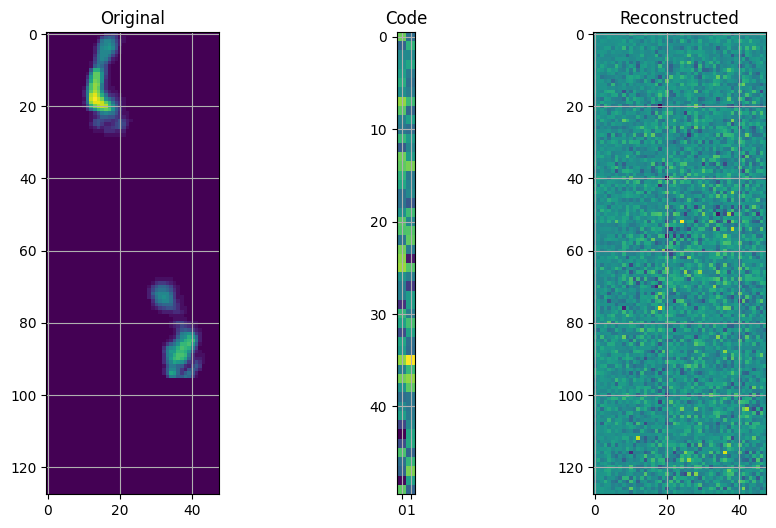

1/1 [==============================] - 0s 19ms/step


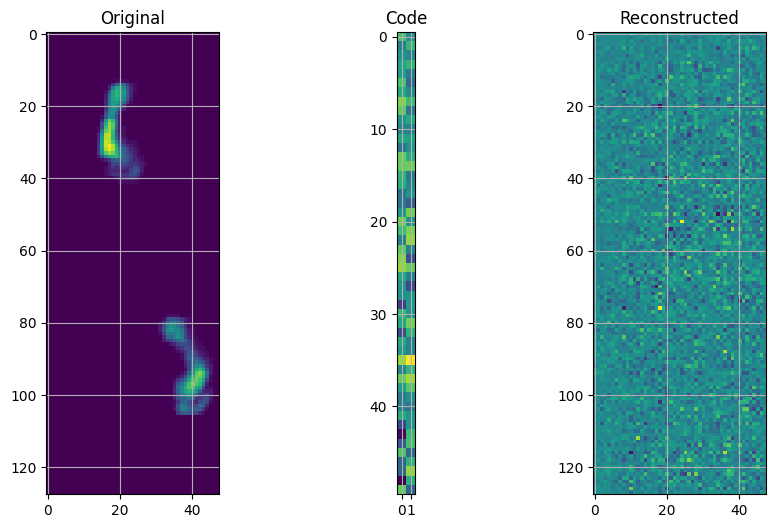

1/1 [==============================] - 0s 19ms/step


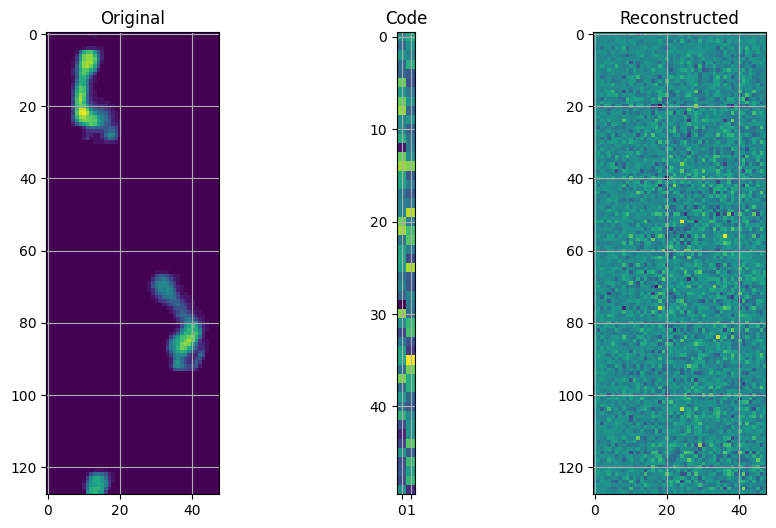

1/1 [==============================] - 0s 20ms/step


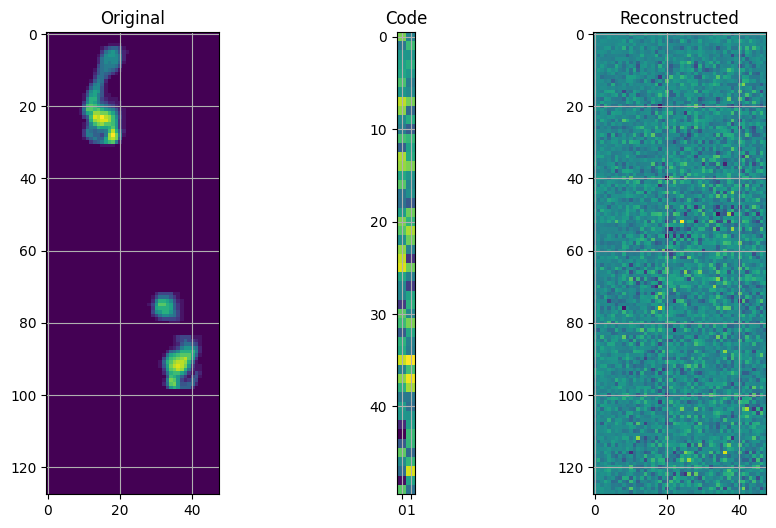

1/1 [==============================] - 0s 19ms/step


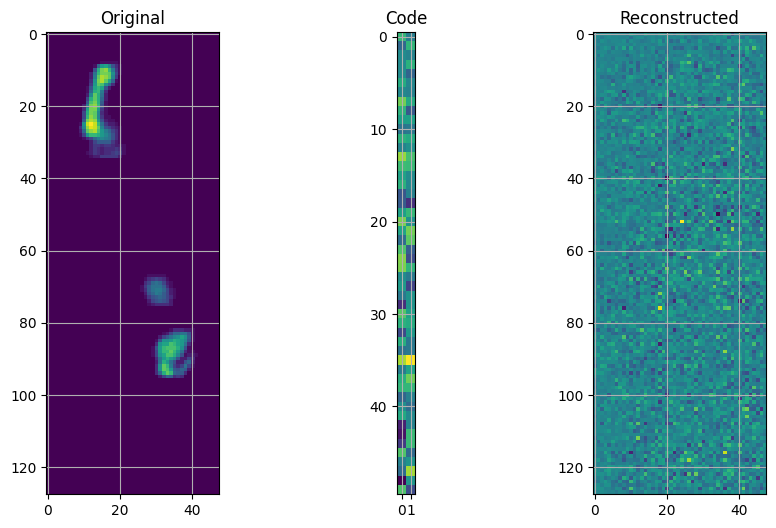

In [ ]:
for i in np.arange(5):
  ps_data = load_data_ps(val_p.index[i], load=False)
  ps_data_norm = normalize_data_ps(ps_data)
  ps_data_norm_center = baricenter(ps_data_norm)

  code = encoder_cnn.predict(ps_data_norm_center[np.newaxis, :])[0]
  reco = decoder_cnn.predict(code[None])[0]

  plt.subplot(1,3,1)
  plt.title("Original")
  plt.imshow(ps_data_norm)

  plt.subplot(1,3,2)
  plt.title("Code")
  plt.imshow(code.reshape([code.shape[-1]//2,-1]))

  plt.subplot(1,3,3)
  plt.title("Reconstructed")
  plt.imshow(reco)
  plt.show()

In [ ]:
path_encoder_CNN = root_directory + '/encoder_CNN.h5'
path_decoder_CNN = root_directory + '/decoder_CNN.h5'

encoder_cnn_load = keras.models.load_model(path_encoder_CNN)
decoder_cnn_load = keras.models.load_model(path_decoder_CNN)

In [ ]:
for i in np.arange(5):
  ps_data = load_data_ps(val_p.index[i], load=False)
  ps_data_norm = normalize_data_ps(ps_data)
  ps_data_norm_center = baricenter(ps_data_norm)

  code = encoder_cnn_load.predict(ps_data_norm_center[np.newaxis, :])[0]
  reco = decoder_cnn_load.predict(code[None])[0]

  plt.subplot(1,3,1)
  plt.title("Original")
  plt.imshow(ps_data_norm_center)

  plt.subplot(1,3,2)
  plt.title("Code")
  plt.imshow(code.reshape([code.shape[-1]//2,-1]))

  plt.subplot(1,3,3)
  plt.title("Reconstructed")
  plt.imshow(reco)
  plt.show()